#### 1. **Unidirectional RNN model using Glove**

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
#loading cleaned data
df = pd.read_csv('/content/cleaned_sentiment.csv', encoding='latin-1')
df.head()

,Tweet,Sentiment
0,Happy Anniversary The Day FreeDUMB Died In tune Don McLean's American Pie,Positive
1,Freedom Convoy as InkBlot Test,Positive
2,Well its pretty easy see what their agenda Pierre has remained silent issues never actually fought convoy just did photo op,Positive
3,You Belong In Jail,Neutral
4,Your head so far up Trudeaus ass can see what had lunch Trudeau does not debate will never answer unscripted question The fringe minoritywas millions who supported Freedom C,Positive


In [118]:
df = df[df['Sentiment'] != 'Neutral']

In [119]:
df['Tweet'] = df['Tweet'].str.replace("'", '').str.replace('"','') #removing atostrophe

<ipython-input-119-d5452c2edf7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweet'] = df['Tweet'].str.replace("'", '').str.replace('"','') #removing atostrophe


In [121]:
df.shape

(33781, 3)

<Axes: xlabel='Sentiment', ylabel='Count'>

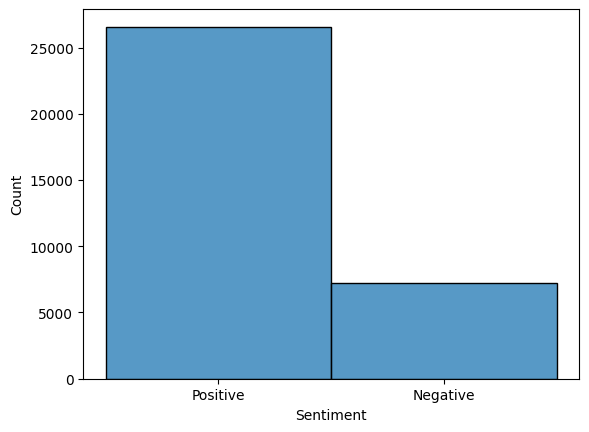

In [122]:
sns.histplot(df["Sentiment"])

In [123]:
#mapping
sentiment_mapping = {'Positive': 1, 'Negative': 0}
df['mapped_sentiment'] = df['Sentiment'].map(sentiment_mapping)
sentiment_counts=df['mapped_sentiment'].value_counts()
print(sentiment_counts)

1.0    26570
0.0     7210
Name: mapped_sentiment, dtype: int64


<ipython-input-123-895db3b120df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mapped_sentiment'] = df['Sentiment'].map(sentiment_mapping)


In [ ]:
#Newdataframe
df

#### Glove for Vectorization

In [ ]:
words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, '/content/glove.6B.50d.txt')  #Glove pre-trained corpus model to represent the tweets
words

In [126]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

In [127]:
lemmatizer = WordNetLemmatizer()

def message_to_token_list(s):
  tokens = tokenizer.tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
  return lemmatized_tokens
message_to_token_list('Happy Anniversary The Day FreeDUMB Died In tune Don McLeans American Pie')

['happy',
 'anniversary',
 'the',
 'day',
 'freedumb',
 'died',
 'in',
 'tune',
 'don',
 'mcleans',
 'american',
 'pie']

In [128]:
def message_to_word_vectors(message, word_dict=words):
  processed_list_of_tokens = message_to_token_list(message)

  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue

    token_vector = word_dict[token]
    vectors.append(token_vector)

  return np.array(vectors, dtype=float)

In [129]:
message_to_word_vectors('Happy Anniversary The Day FreeDUMB Died In tune Don McLeans American Pie').shape

(11, 50)

In [130]:
train_df = df.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.7)
split_index_2 = int(len(train_df) * 0.85)

train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(23646, 5067, 5068)

In [131]:
def df_to_X_y(dff):
  y = dff['mapped_sentiment'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for message in dff['Tweet']:
    message_as_vector_seq = message_to_word_vectors(str(message))

    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)

  return all_word_vector_sequences, y

In [132]:
X_train, y_train = df_to_X_y(train_df)

print(len(X_train), len(X_train[8]))

<ipython-input-131-70e2dd51e7b7>:2: RuntimeWarning: invalid value encountered in cast
  y = dff['mapped_sentiment'].to_numpy().astype(int)


23646 30


In [157]:
print(y_train[12])

1


In [ ]:
sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [134]:
pd.Series(sequence_lengths).describe()

count    23646.000000
mean        19.570837
std          9.005219
min          1.000000
25%         12.000000
50%         20.000000
75%         27.000000
max         50.000000
dtype: float64

In [135]:
from copy import deepcopy

def pad_X(X, desired_sequence_length=55):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len

    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])

  return np.array(X_copy).astype(float)

In [136]:
X_train = pad_X(X_train)

X_train.shape

(23646, 55, 50)

In [137]:
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val)

X_val.shape, y_val.shape

((5067, 55, 50), (5067,))

In [138]:
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test)

X_test.shape, y_test.shape

((5068, 55, 50), (5068,))

## Model Building

In [139]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
model = Sequential([])

model.add(layers.Input(shape=(55, 50)))
model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.SimpleRNN(128, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [161]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [162]:
model.fit(X_train, y_train, epochs=11)

Epoch 1/11
739/739 [==============================] - 72s 92ms/step - loss: 741190156681216.0000 - accuracy: 0.7810
Epoch 2/11
739/739 [==============================] - 69s 93ms/step - loss: -463767078961152.0000 - accuracy: 0.7184
Epoch 3/11
739/739 [==============================] - 66s 89ms/step - loss: -1382950746718208.0000 - accuracy: 0.5614
Epoch 4/11
739/739 [==============================] - 66s 89ms/step - loss: -3934892807159808.0000 - accuracy: 0.4353
Epoch 5/11
739/739 [==============================] - 64s 87ms/step - loss: -3812708235345920.0000 - accuracy: 0.3993
Epoch 6/11
739/739 [==============================] - 67s 90ms/step - loss: -5448615912800256.0000 - accuracy: 0.2916
Epoch 7/11
739/739 [==============================] - 63s 86ms/step - loss: -9232877237567488.0000 - accuracy: 0.2631
Epoch 8/11
739/739 [==============================] - 66s 89ms/step - loss: -10610797235404800.0000 - accuracy: 0.2458
Epoch 9/11
739/739 [==============================] - 66s 

In [168]:
test_predictions =model.predict(X_test).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_test, test_predictions))

159/159 [==============================] - 6s 38ms/step
              precision    recall  f1-score   support

           0       0.21      1.00      0.35      1060
           1       1.00      0.00      0.00      4008

    accuracy                           0.21      5068
   macro avg       0.60      0.50      0.17      5068
weighted avg       0.83      0.21      0.07      5068

